In [1]:
import pickle
from copy import deepcopy

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import numpy as np; np.set_printoptions(suppress=True, linewidth=180)
import pandas as pd; pd.set_option('display.width', 500)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import ipywidgets as widgets
from ipyfilechooser import FileChooser

from plot_module import plot_ode_results, plot_sde_results, plot_simulator_graph, plot_neuron_graph_subset
from sim_param_from_network import names_from_network, sde_param_from_network, ode_from_network, start_state_from_nodes
from neuron_graph_process import neuron_graph_process
from neuron_graph_helper import load_pickled_neuron_graph

from simulate import simulate_ode, simulate_gillespie, simulate_tauleaping

In [2]:
# Specify the directory
directory = 'neuron_shape_data'
fc = FileChooser(directory)
display(fc)
file_path = fc.selected

FileChooser(path='/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data', filename='', t…

In [3]:
#temp_fp = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/m_hippocampus_NMO_97827.pkl'
file_path = '/home/daniel/Projects/2023_Jones_Lab_mtDNA/SSD/SSD_Neuron/neuron_shape_data/h_cerebellum_interneuron_NMO_32551.pkl'

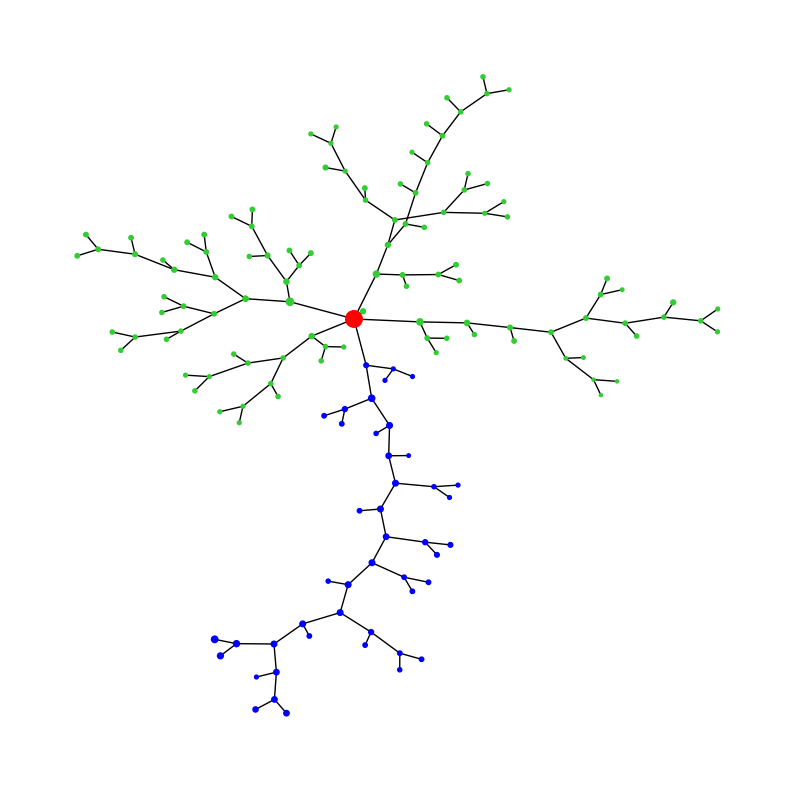

In [4]:
imported_neuron_graph = load_pickled_neuron_graph(file_path)
plot_neuron_graph_subset(imported_neuron_graph)

In [5]:
DELTA = 0.7
DEATH_RATE = 0.4
SWITCH_RATE_AR = 0.01
SWITCH_RATE_RA = 0.01
TRANSP_SPEED = 14000

SOMA_CB = 0.1
SOMA_BR = 3.2
SOMA_NSS = 500
SOMA_DIFFUSION = 0.5
SOMA_MITO_DENSITY = 2 # number of mt/um^3 of volume

AXON_MITO_DENSITY = 2 # number of mt/um^3 of volume
AXON_TRNSP_ANT = 8
AXON_TRNSP_RET = 6

DENDRITE_MITO_DENSITY = 2 # number of mt/um^3 of volume

bio_param = {
    # global parameters    
    'delta': DELTA, 
    'switch_rate_ar': SWITCH_RATE_AR,
    'switch_rate_ra': SWITCH_RATE_RA,
    
    # soma parameters
    'soma_death_rate': DEATH_RATE, 
    'soma_mito_density': SOMA_MITO_DENSITY,
    'soma_cb': SOMA_CB, 
    'soma_br': SOMA_BR, 
    'soma_diffusion': SOMA_DIFFUSION,
    'soma_nss': None,
    
    # axon parameters
    'axon_death_rate': DEATH_RATE, 
    'axon_mito_density':AXON_MITO_DENSITY,
    'axon_nss': None,
    'axon_transp_speed': TRANSP_SPEED,
    'axon_terminal_influx': None,
    'axon_terminal_efflux': None,

    # dendrite paramters
    'dendrite_death_rate': DEATH_RATE, 
    'dendrite_mito_density': SOMA_MITO_DENSITY,
    'dendrite_nss': None,
    'dendrite_transp_speed': TRANSP_SPEED,
    'dendrite_terminal_influx': None,
    'dendrite_terminal_efflux': None,
    }

In [6]:
imported_neuron_graph = nx.Graph()
imported_neuron_graph.add_node('1', nodetype = 1, nss = 200, volume = 200, radius = 1, xy = (0,0))
imported_neuron_graph.add_node('2', nodetype = 2, nss = 200, volume = 200, radius = 1, xy = (0, 1))
imported_neuron_graph.add_edge('1','2', edgetype = 2, volume = 200, len = 1)

# imported_neuron_graph.add_node('3', nodetype = 2, nss = 200, volume = 200, radius = 1, xy = (0, 1))
# imported_neuron_graph.add_edge('2','3', edgetype = 2, volume = 200, len = 1)

bio_param['axon_nss'] = 100
bio_param['soma_nss'] = 200
bio_param['dendrite_nss'] = 200
bio_param['dendrite_terminal_influx'] = 20
bio_param['dendrite_terminal_efflux'] = 10


> Inferring net influx and efflux at at axon and dendrite terminals.
at a death rate of 0.4, a target axon pop. of 100, requires an influx of 80.0 mt and an outflow of 40.0 mt

>> Transforming input graph:
> The undirected input graph has 2 nodes, and 1 edges. Found 1 branches:
axon of 1 nodes, total volume is 200 um^3
> the directed output graph has 2 nodes, and 2 edges

>> Adding biological parameters to the network


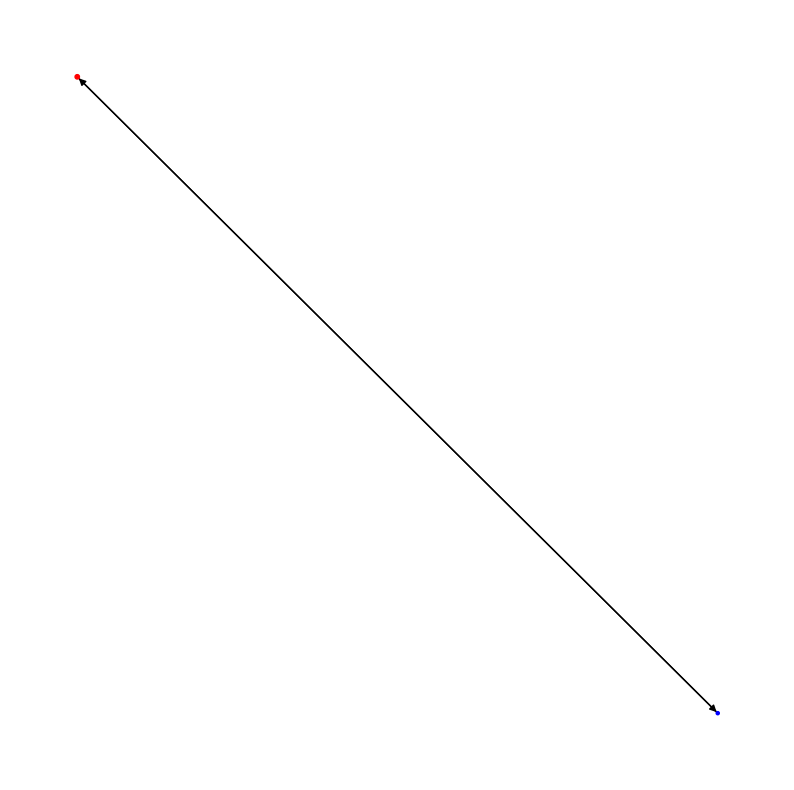


>>> Solving arbor subgraphs flows...

>> Solving subgraph 0

> Total outflow to this branch is 40.0 mt/day

<<< Finished solving >>>


> Adjusting soma birth rates to 0.6 to match steady state demand from:
80.0 deaths (80.0/node), and 40.0 net outflow (40/node) to the arbors.

>>> Solving within-soma flows...

<<< Finished solving >>>



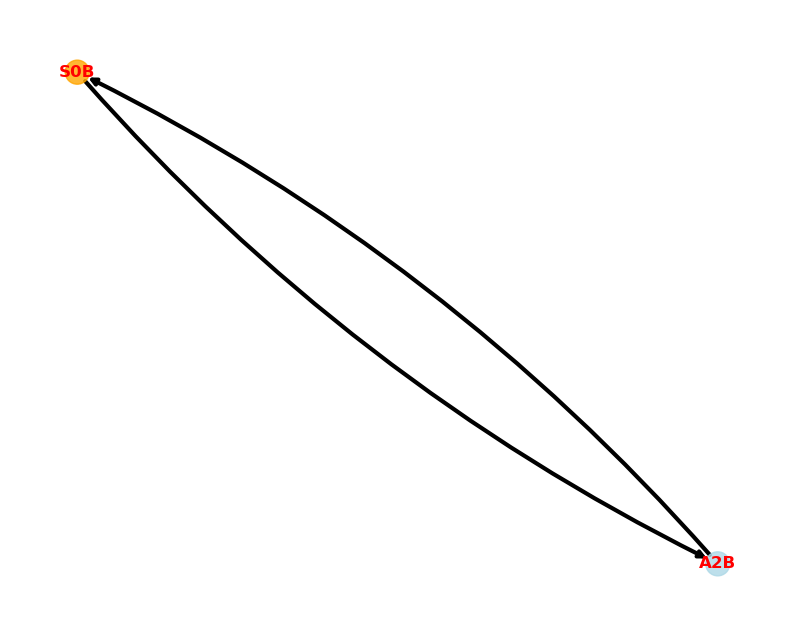

In [7]:
G = neuron_graph_process(
    input_graph = imported_neuron_graph,
    input_bio_param = bio_param,
    transform_type = 'bidirect',
    n_soma_nodes = 1,
    soma_g_type = 'complete',
    prnt = False,
    plot = True
)
plot_simulator_graph(G)

In [8]:
TIME_POINTS = np.linspace(0, 100, 1001)
VARS, NODES = names_from_network(G)
START_STATE = start_state_from_nodes(G, heteroplasmy=0.5, delta=DELTA)

# infer the ode model
ode_model = ode_from_network(G, prnt=False)

# infer the parameterse of the sde systems
SDE_PARAM = sde_param_from_network(G, prnt=False)

# simulate system a bit, and allow to stabilize before running the full sims
START_STATE = simulate_ode(ode_model, np.linspace(0, 1000, 1001), START_STATE)[:,-1]

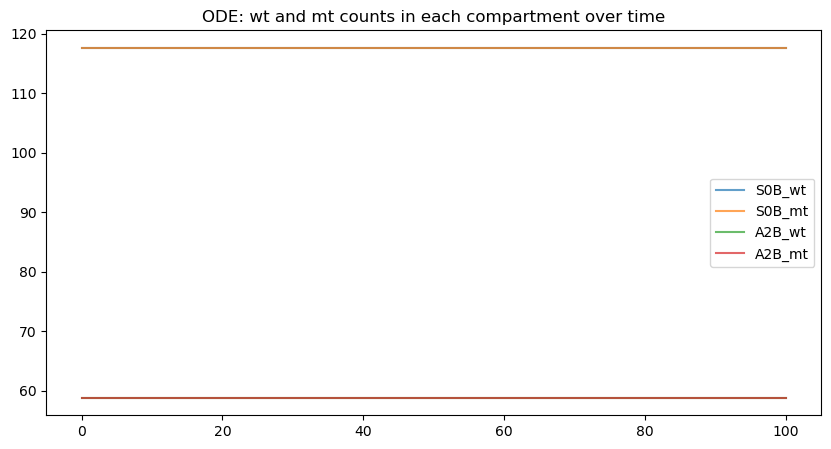

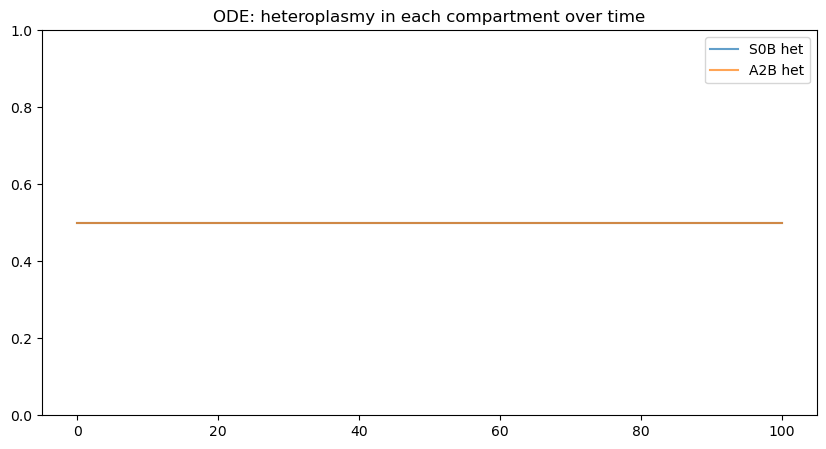

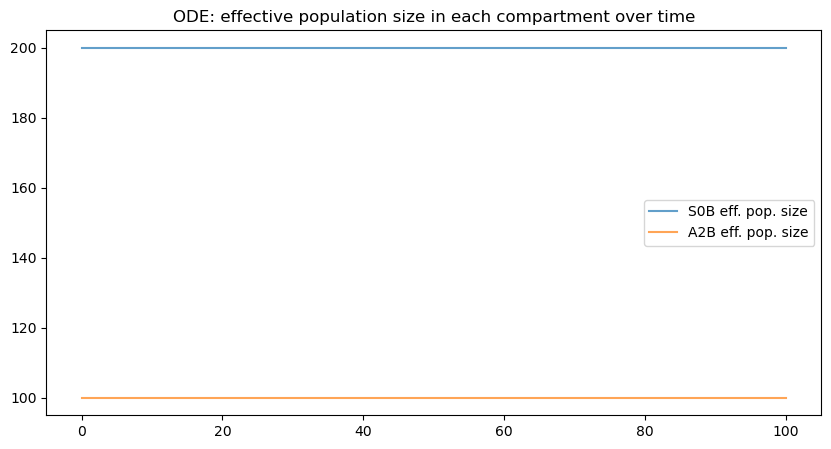

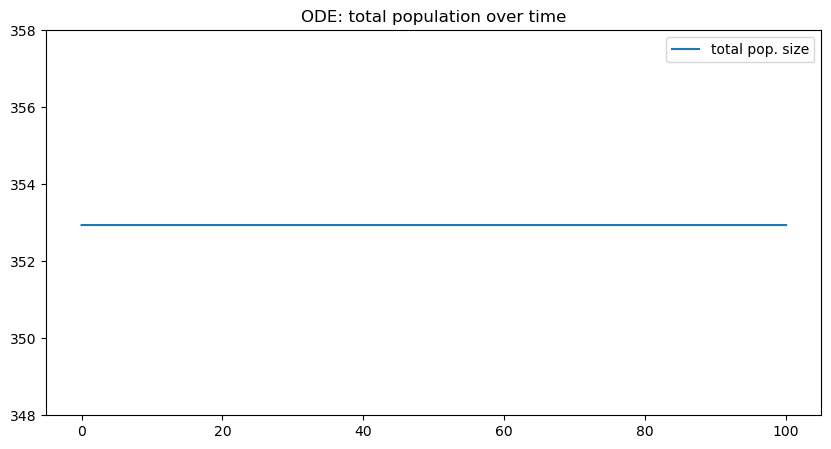

In [9]:
ode_results = simulate_ode(ode_model, TIME_POINTS, START_STATE)
plot_ode_results(ode_results, TIME_POINTS, DELTA, VARS, NODES, prnt=False)

simulating...


100%|██████████| 1000/1000 [00:00<00:00, 1124.46it/s]


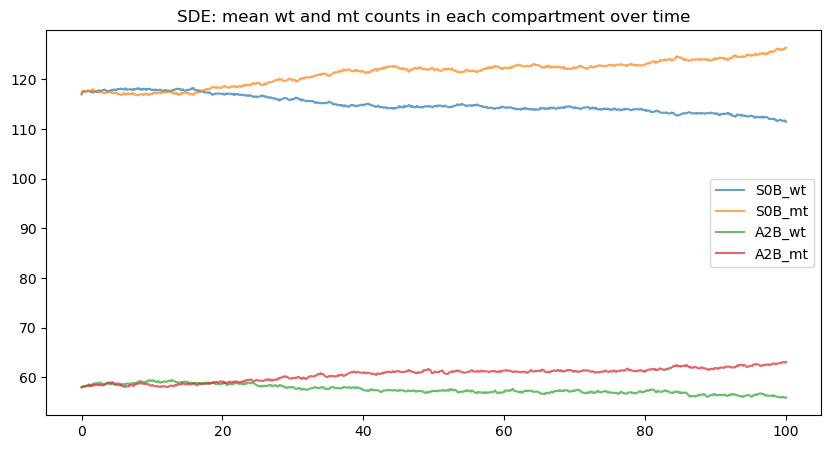

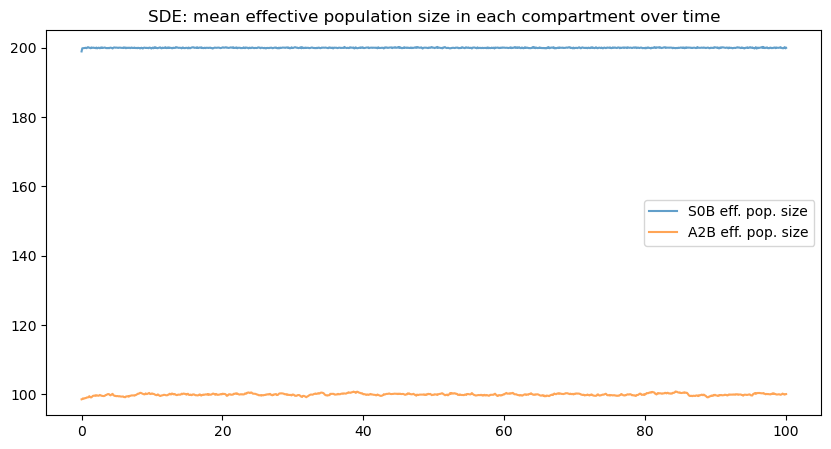

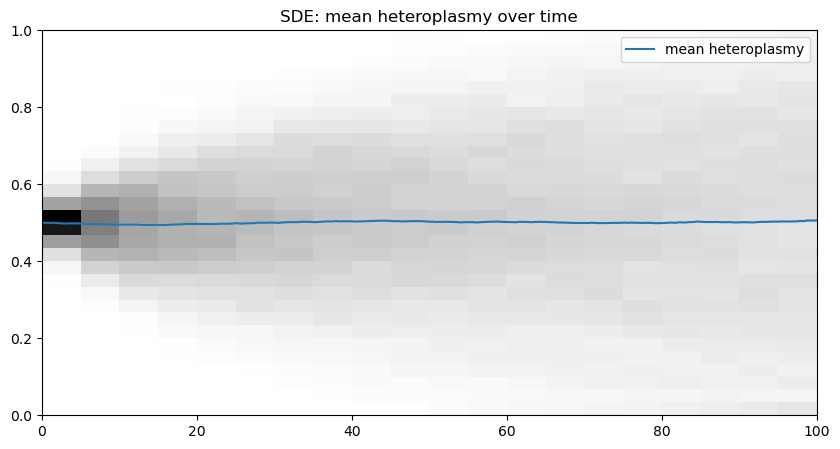

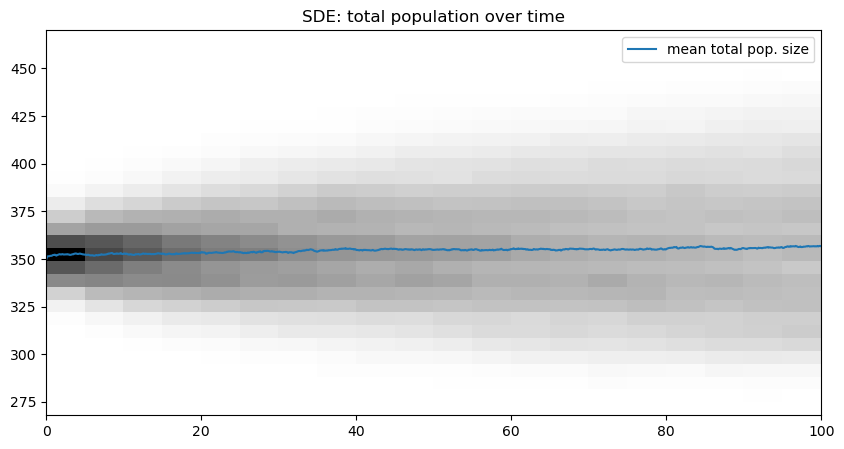


> Change in mean heteroplasmy: 
start: 0.5
final: 0.5063
delta: 0.0063


In [10]:
gillespie_results = simulate_gillespie(SDE_PARAM, TIME_POINTS, START_STATE, replicates=1000)
plot_sde_results(gillespie_results, TIME_POINTS, DELTA, VARS, NODES, prnt = False)

simulating...


100%|██████████| 1000/1000 [00:00<00:00, 1278.64it/s]


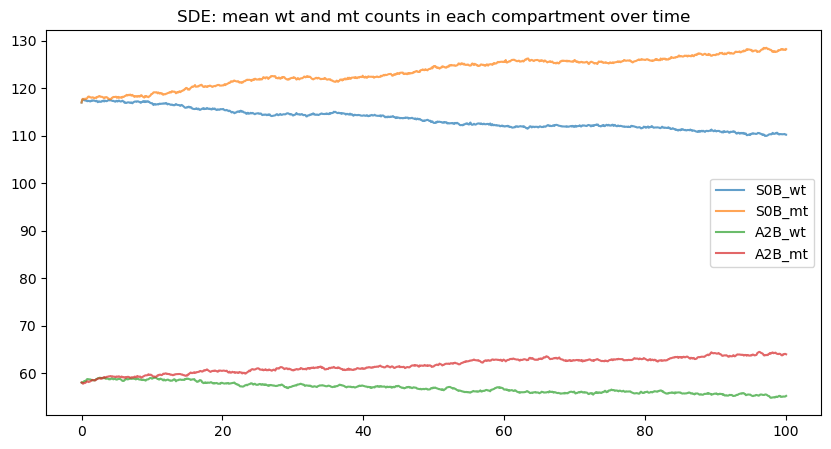

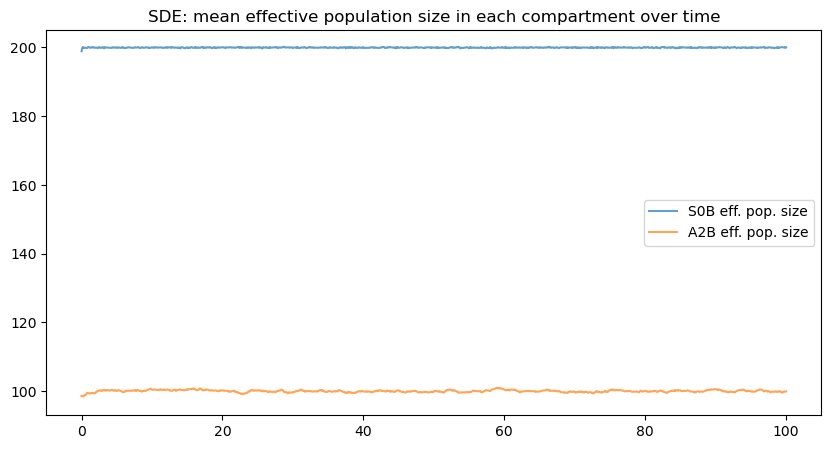

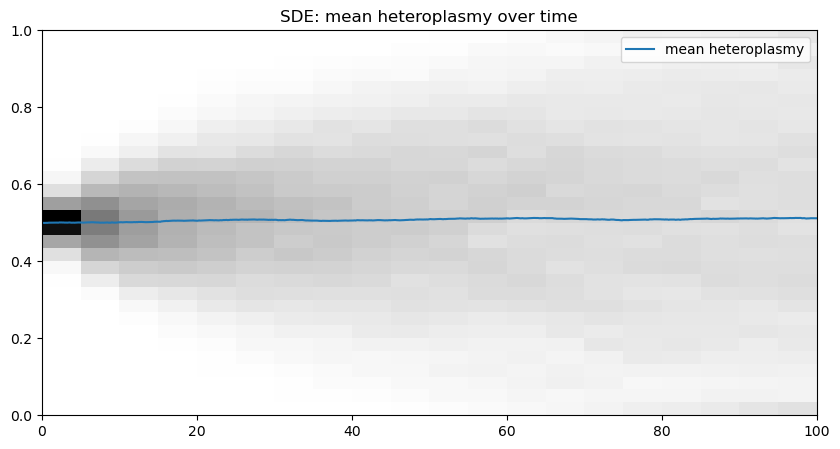

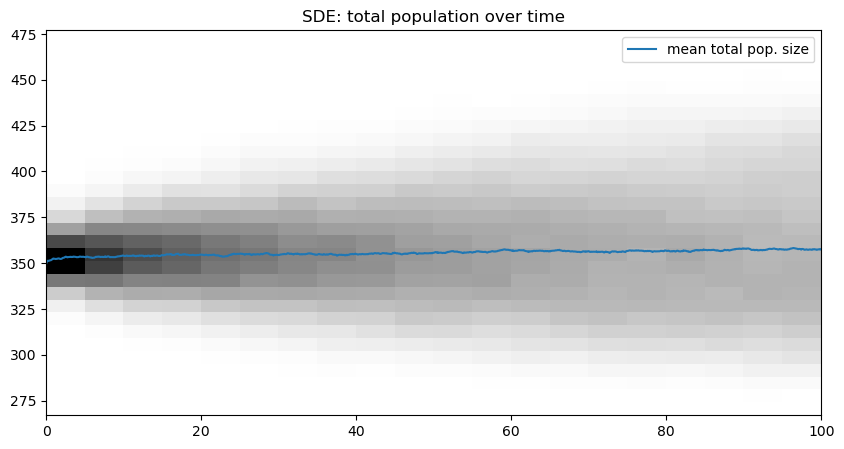


> Change in mean heteroplasmy: 
start: 0.5
final: 0.5117
delta: 0.0117


In [11]:
tauleaping_results = simulate_tauleaping(SDE_PARAM, TIME_POINTS, START_STATE, replicates=1000, timestep=0.01)
plot_sde_results(tauleaping_results, TIME_POINTS, DELTA, VARS, NODES, prnt = False)